In [1]:
%load_ext autoreload
%autoreload 2
from typing import Callable

import numpy as np
from matplotlib import pyplot as plt


from main.tree import Tree, TreeTypes
from main.score import Score
from main.stats import (
    histogram_pairs_siblings,
    histogram_pairs_parent_child,
    scatter_pairs,
    boxplot_scores,
    display_str,
    input_data,
    get_siblings_data,
    get_parent_child_data
)

def f(x: list[TreeTypes], y: list[TreeTypes], fn: Callable[[Tree], list[Score]]): return x, y, fn

def expandable_mols(tree: Tree): return [smiles.score for smiles in tree.expandable]
def all_mols(tree: Tree): return [smiles.score for smiles in (tree.expandable + tree.in_stock)]

detailed=False

SIBLINGS = 0
PARENTAL = 1
analyzed_pairs = PARENTAL
    
if analyzed_pairs  == SIBLINGS:
    analyzed_types = [
        (["internal"], ["not_solved"], all_mols),
    #     (["internal", "solved"], ["not_solved"], all_mols),
    #     (["solved"], ["internal"], all_mols),
        (["solved"], ["not_solved"], all_mols),
        (["internal"], ["not_solved"], expandable_mols)
    ]
    data = get_siblings_data(analyzed_types, detailed)
    dump_name = "results/table_siglings_mf.csv"
elif analyzed_pairs == PARENTAL:
    analyzed_types = [
        (["internal"], ["not_solved"], all_mols),
    #     (["internal", "solved"], ["not_solved"], all_mols),
    #     (["solved"], ["internal"], all_mols),
    #     (["solved"], ["not_solved"], all_mols),
        (["internal"], ["not_solved"], expandable_mols)
    ]

    data = get_parent_child_data(analyzed_types, detailed)
    dump_name = "results/table_parental_mf.csv"

USE_MF = True

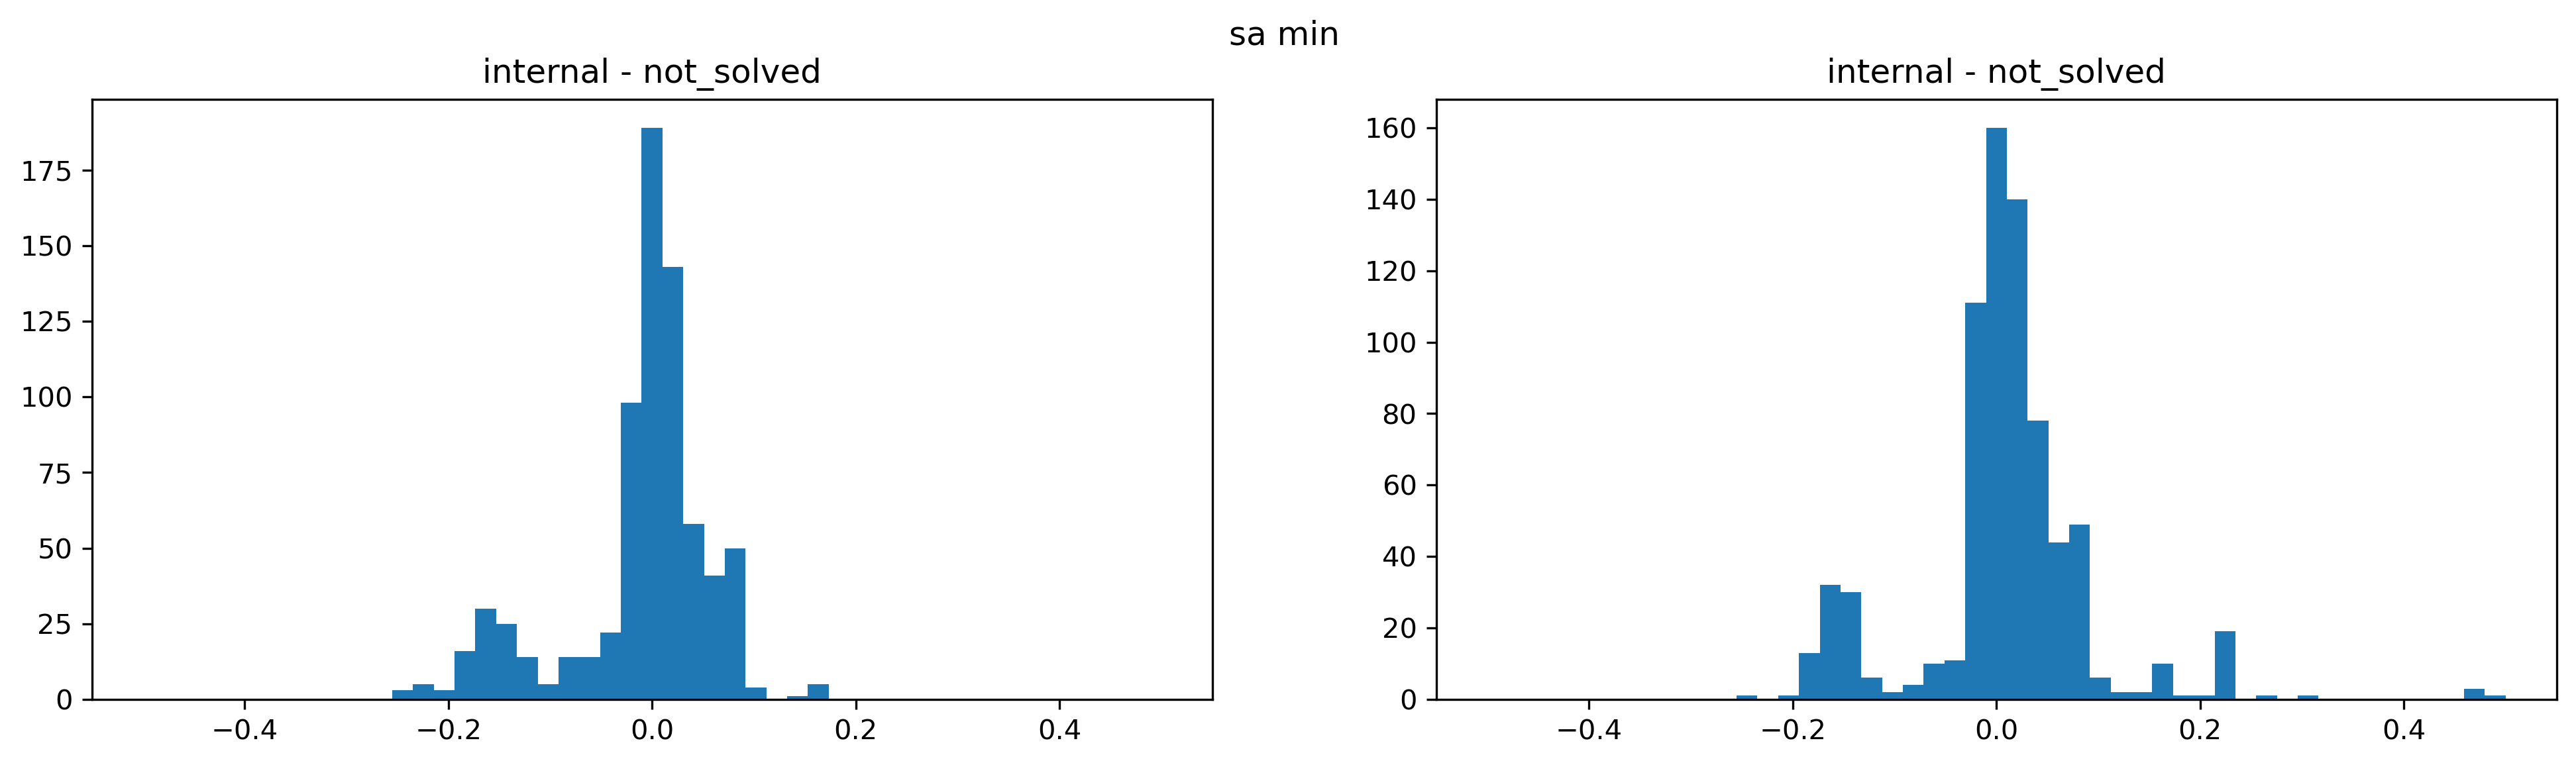

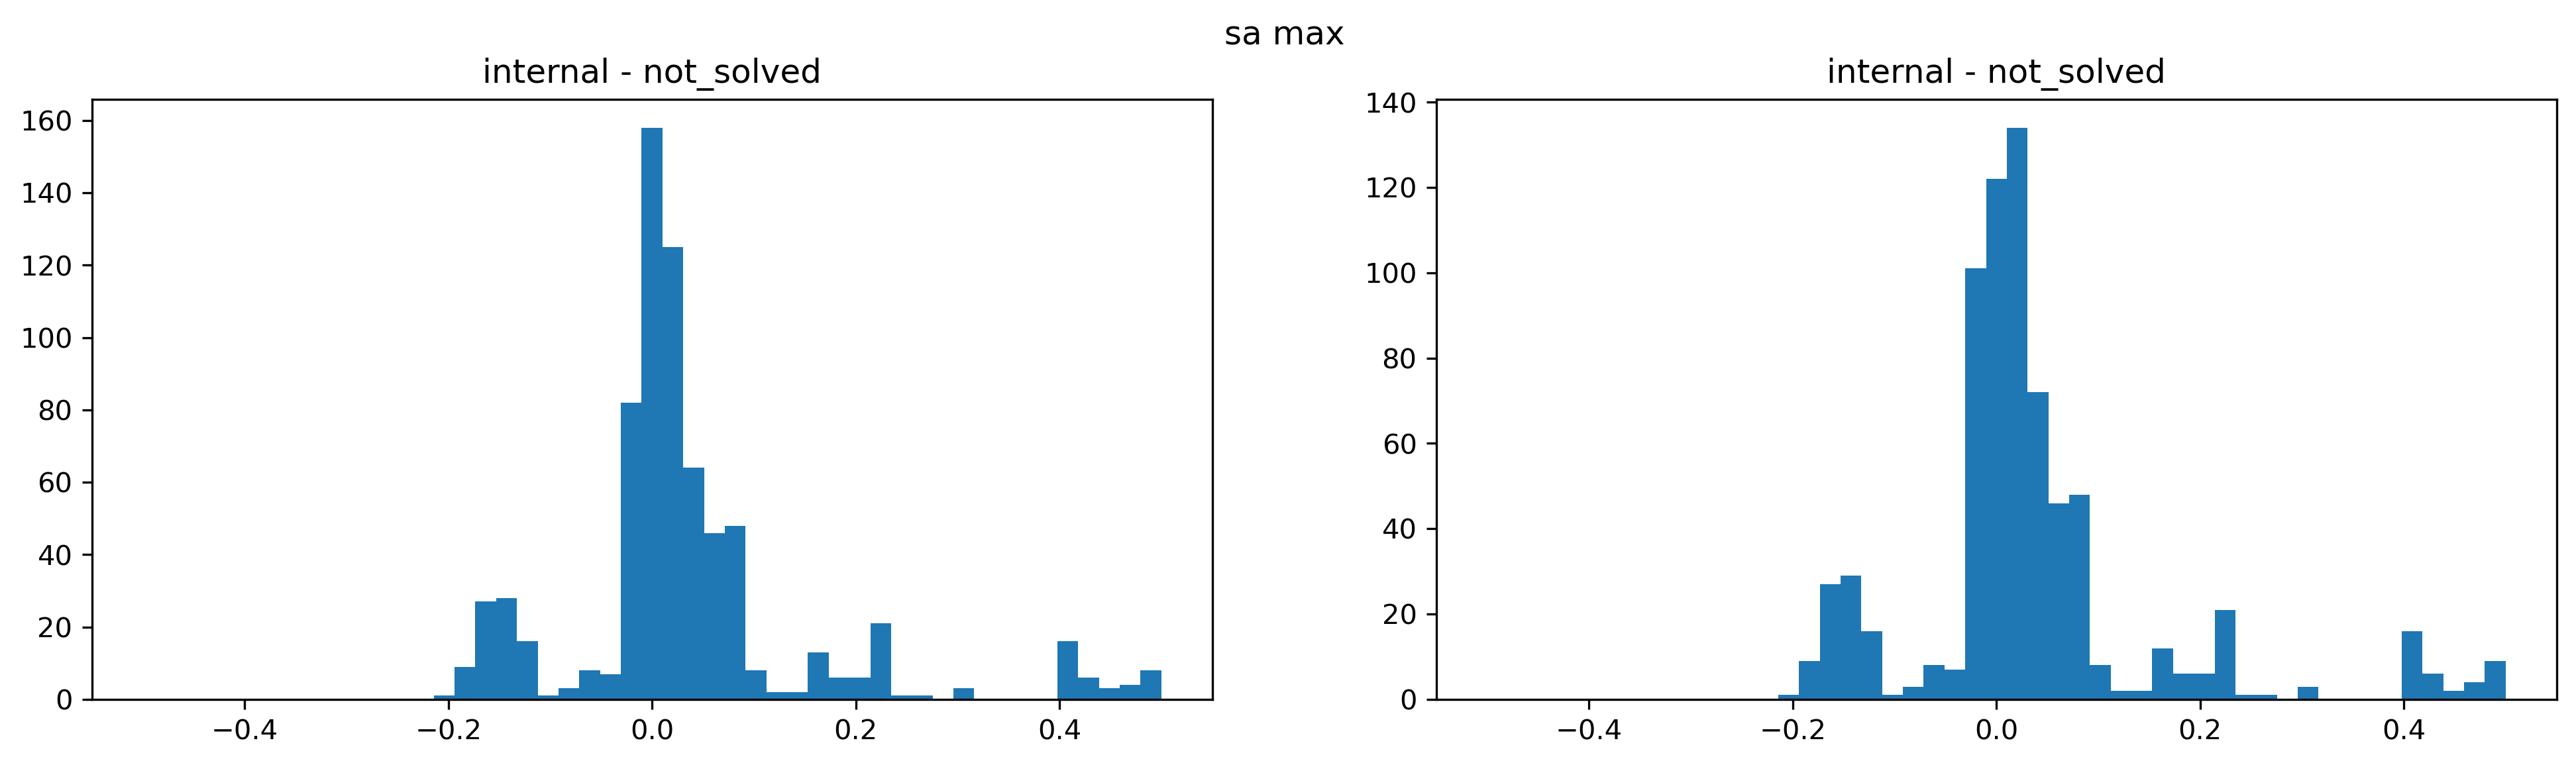

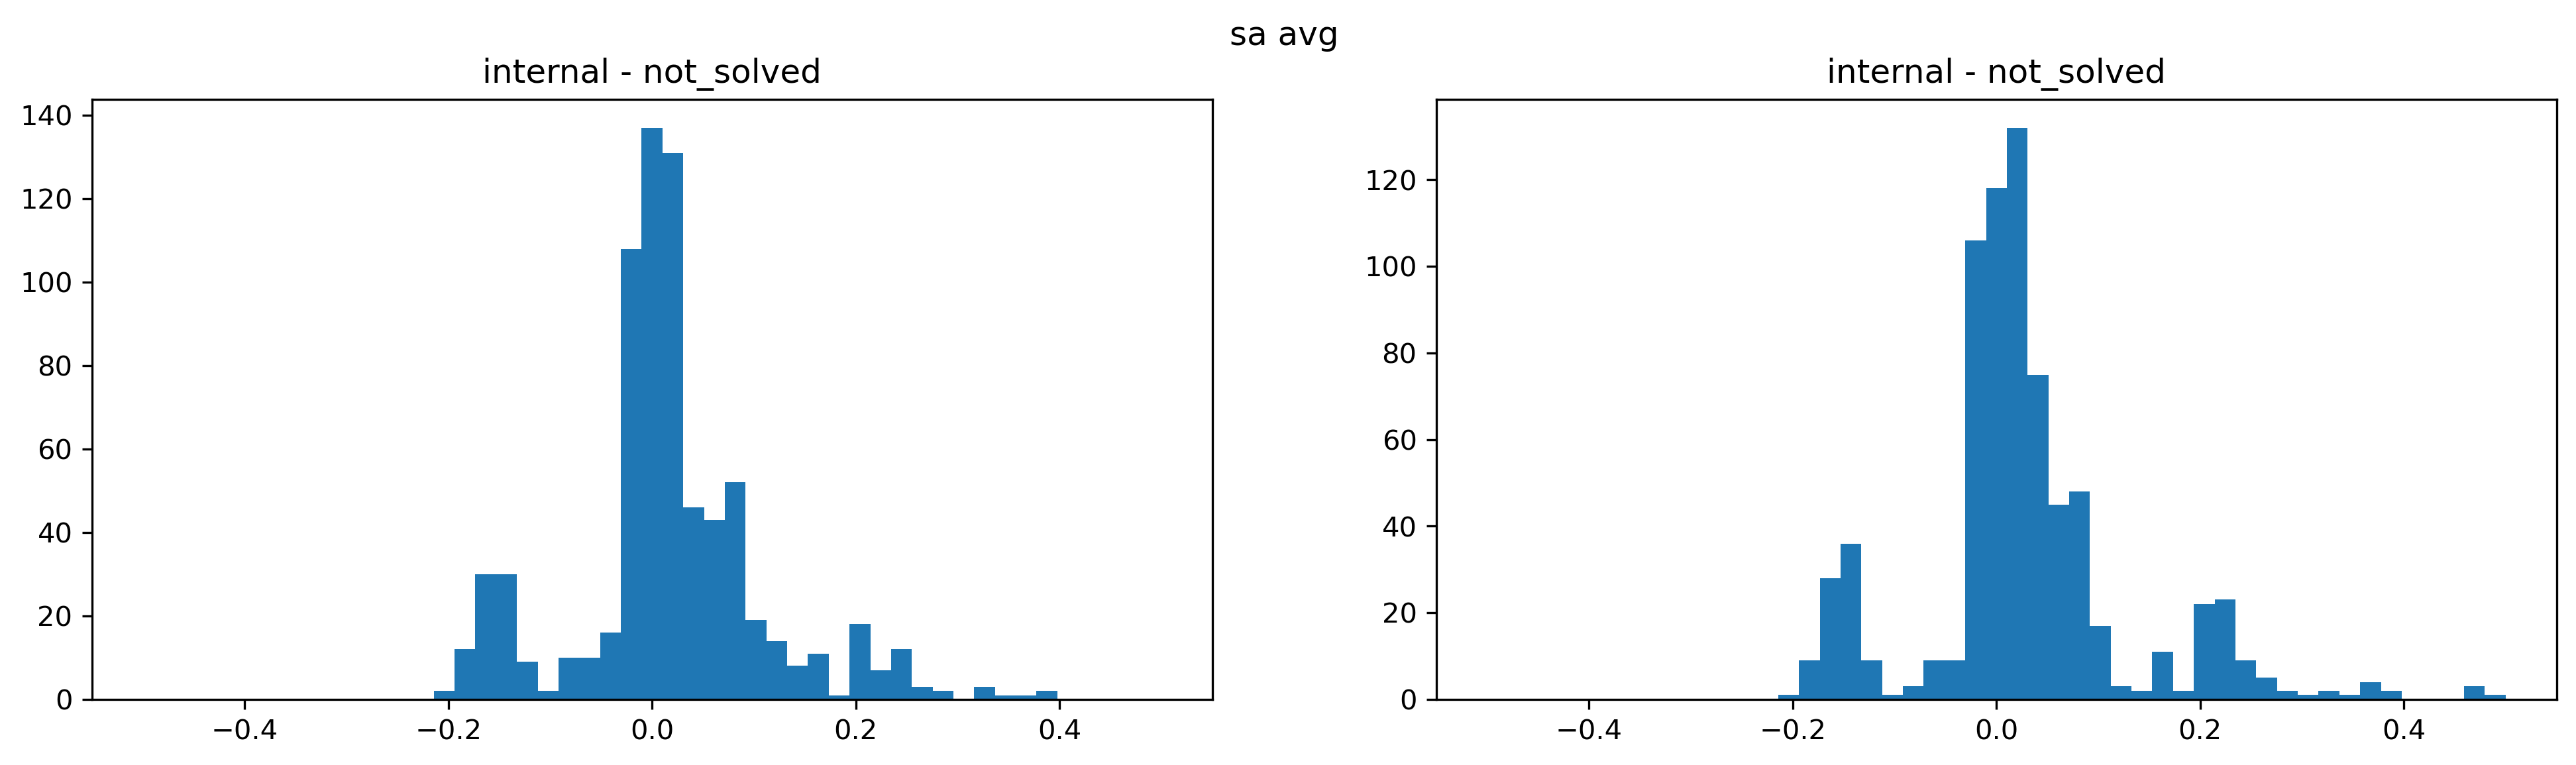

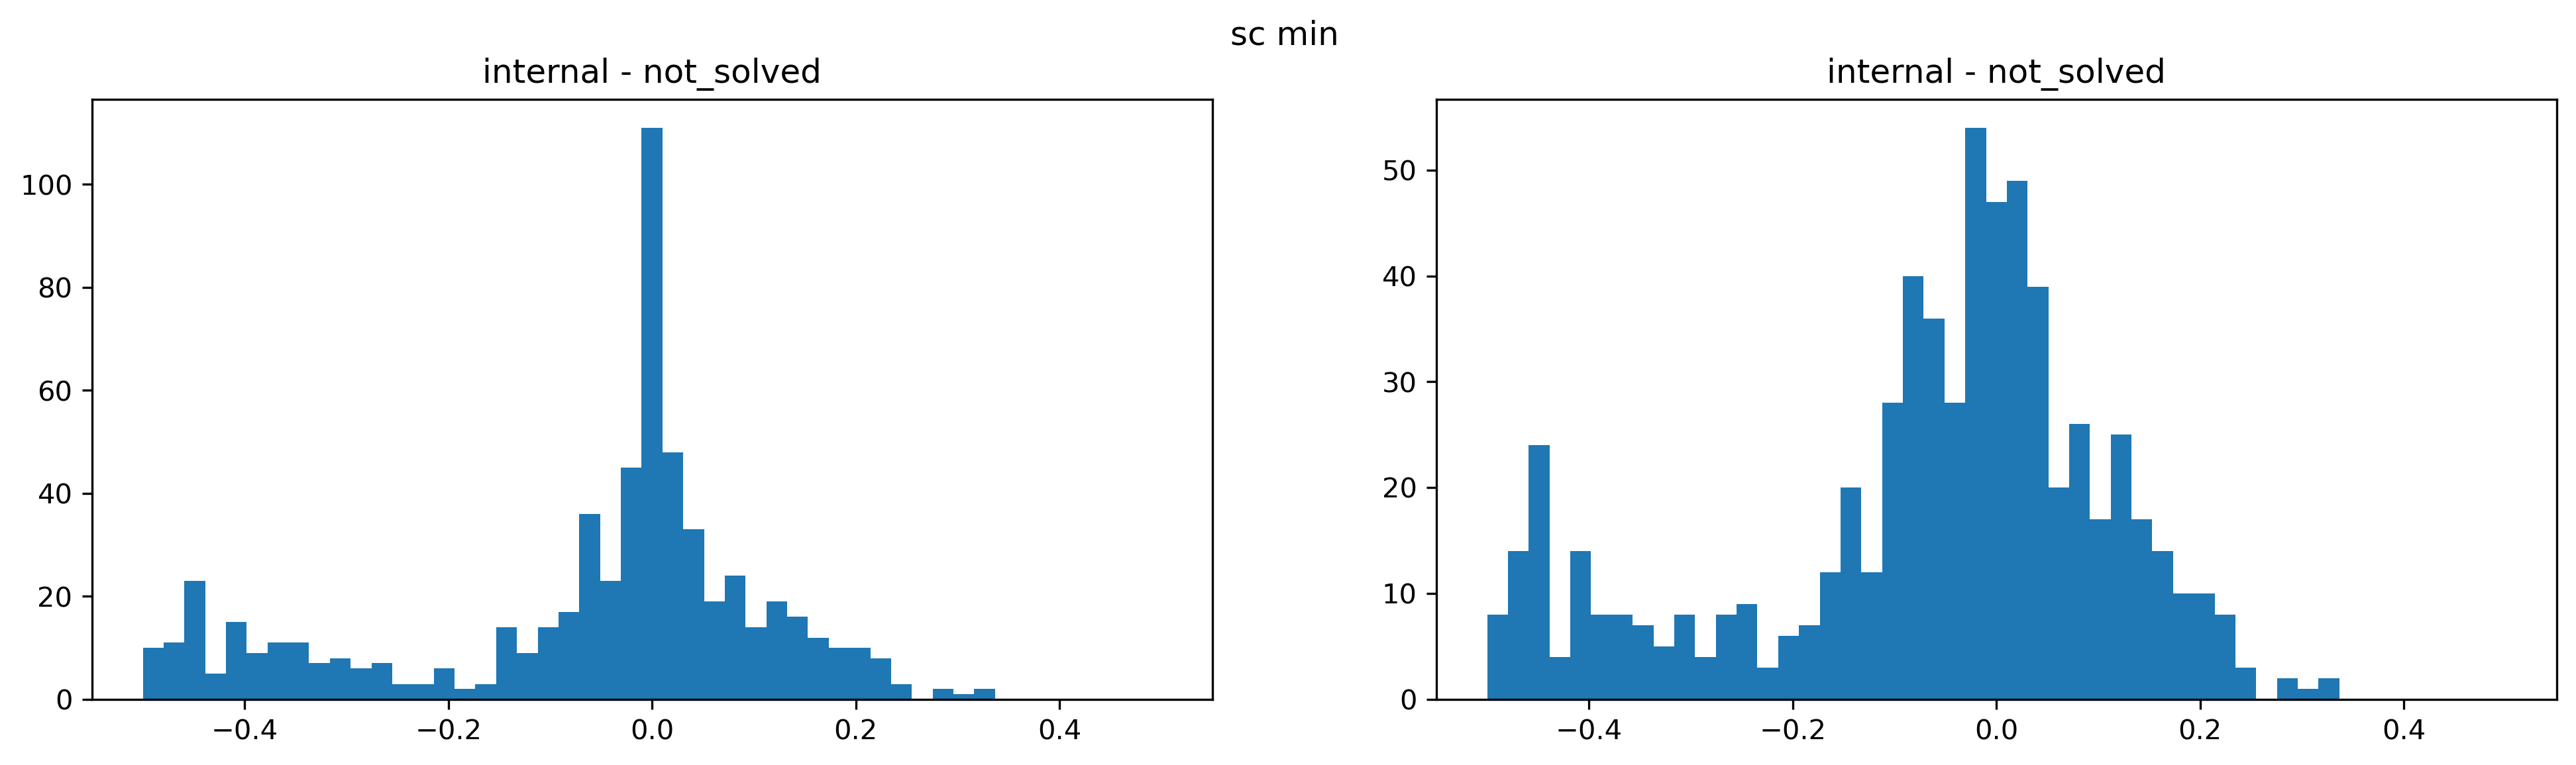

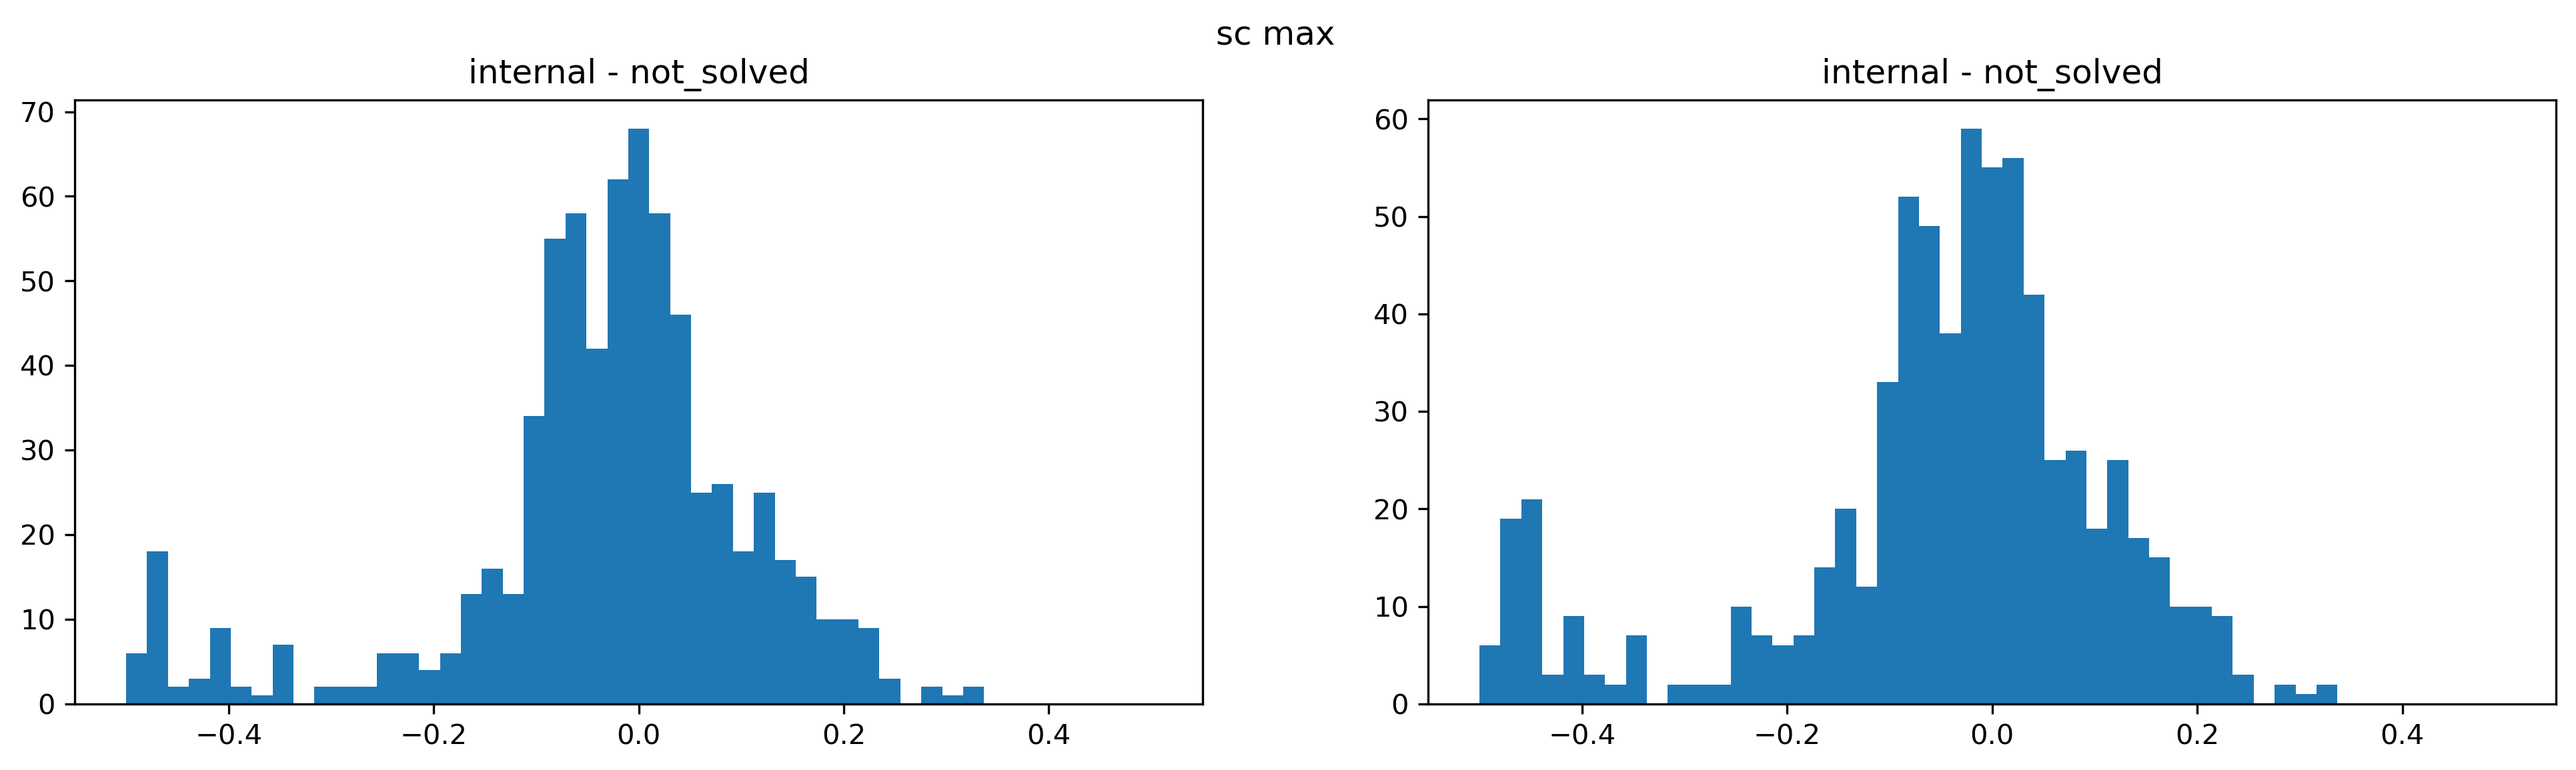

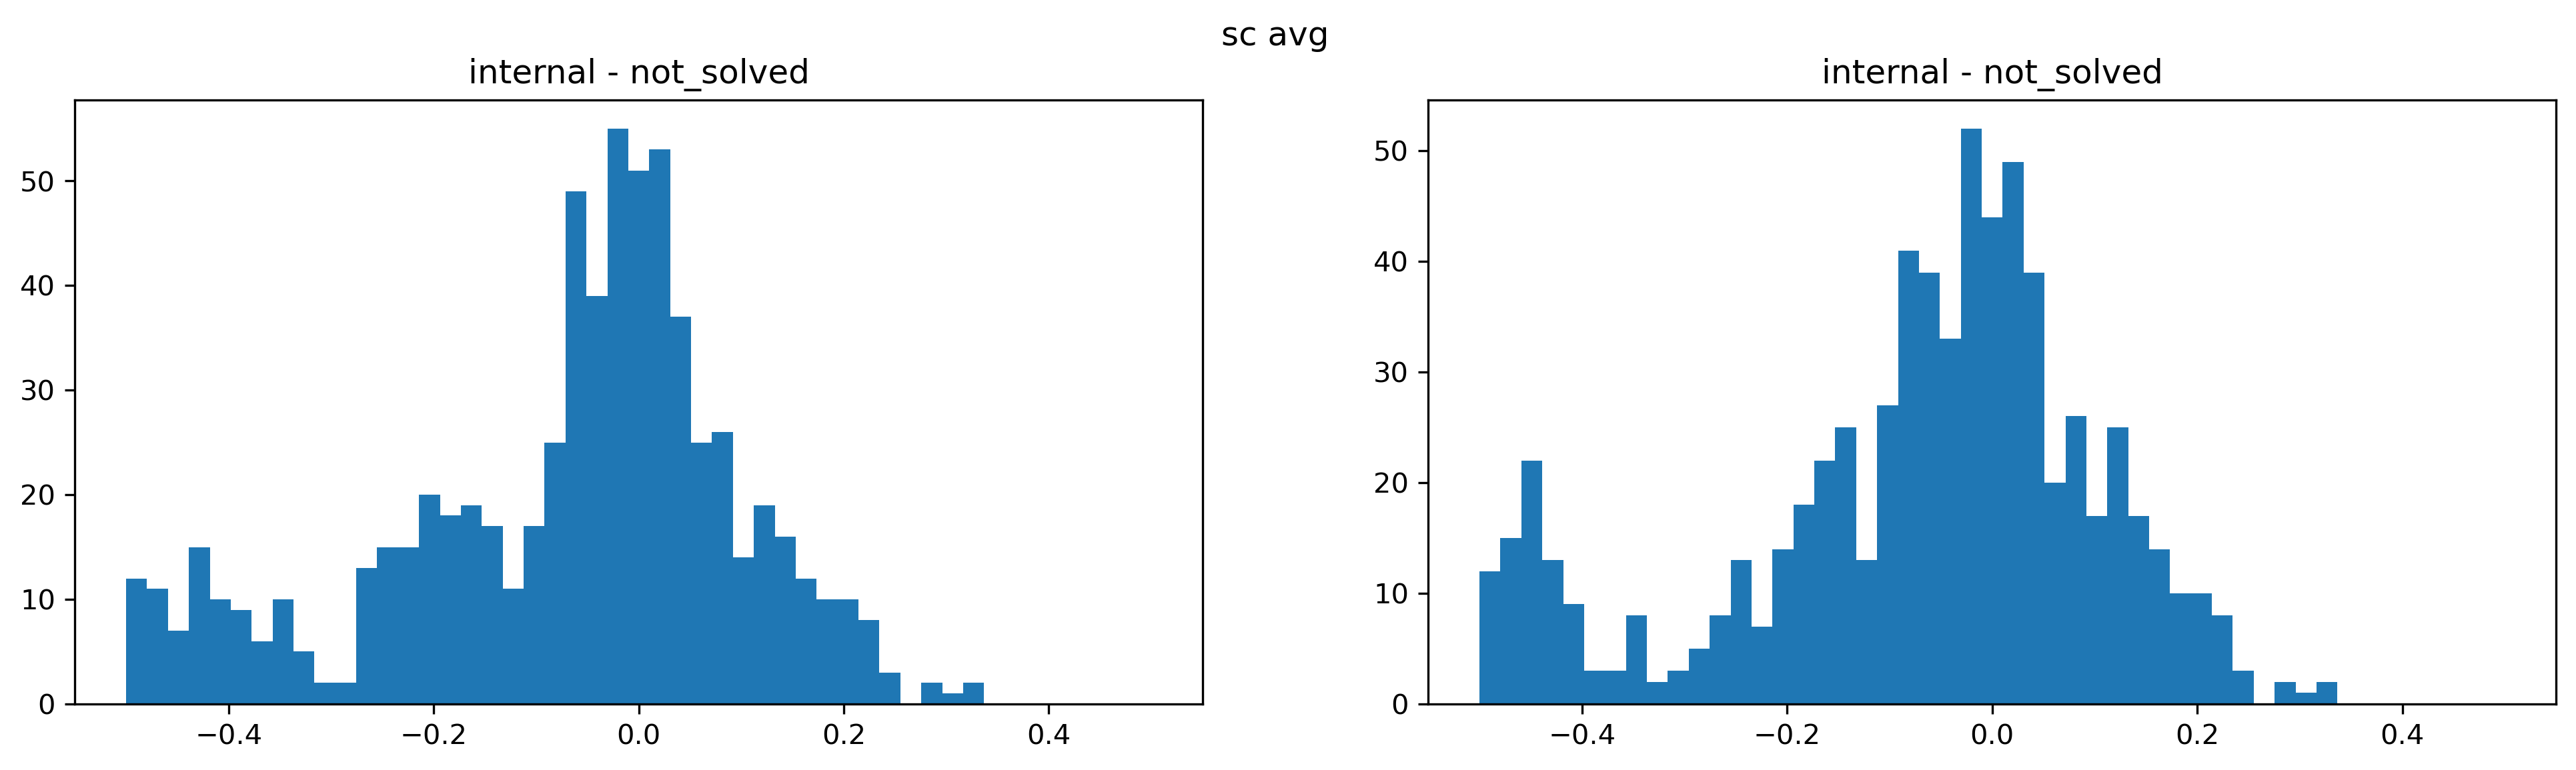

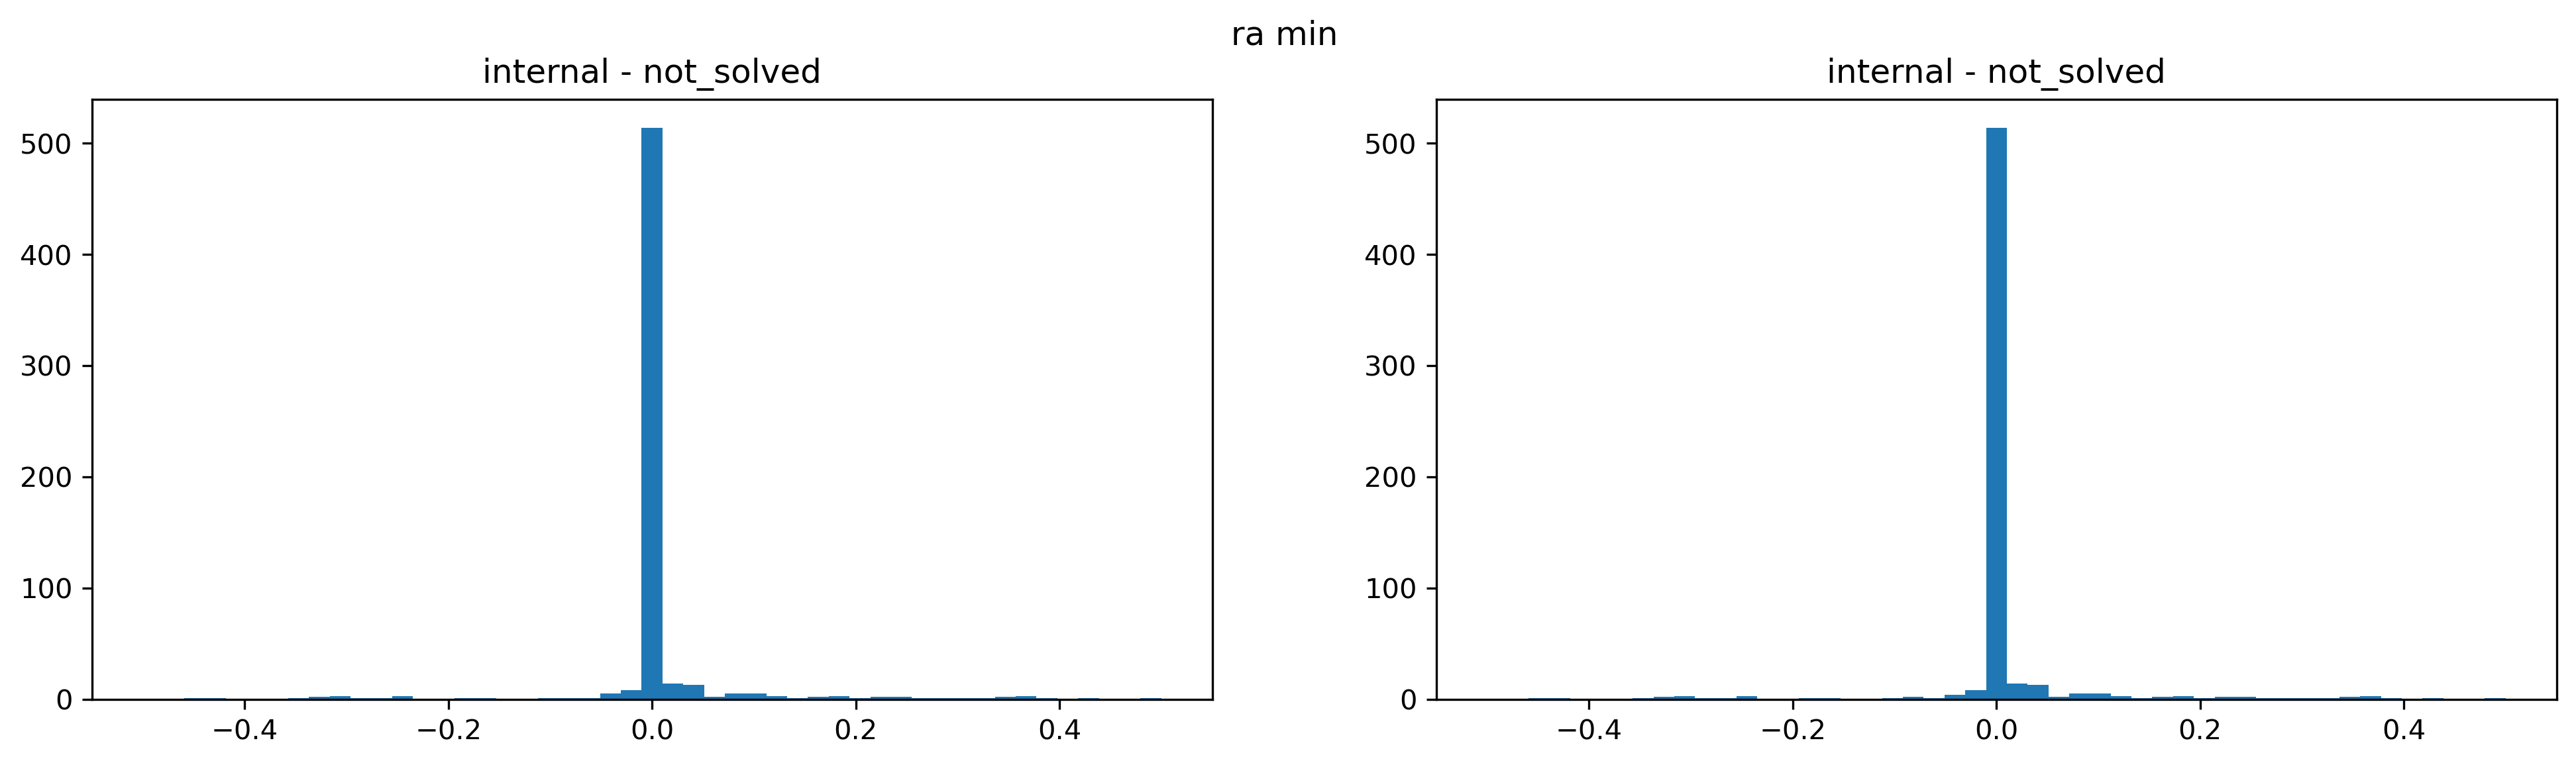

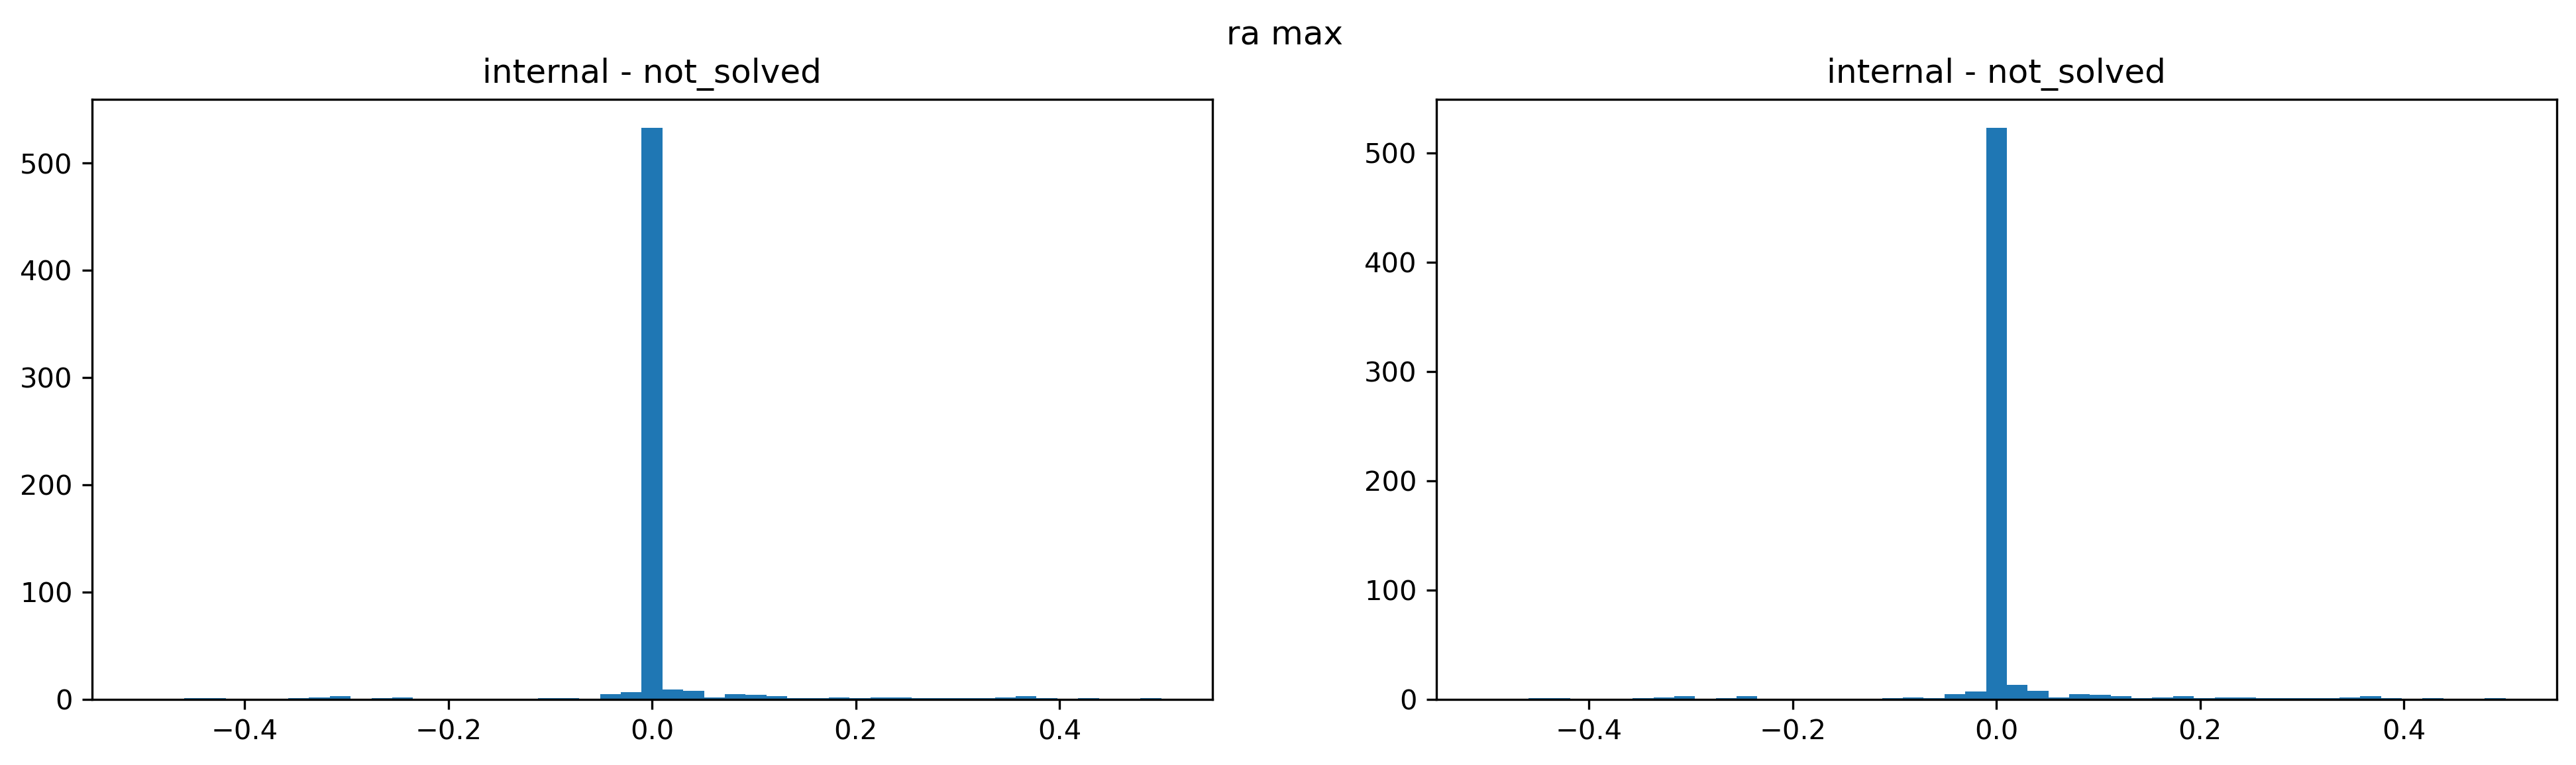

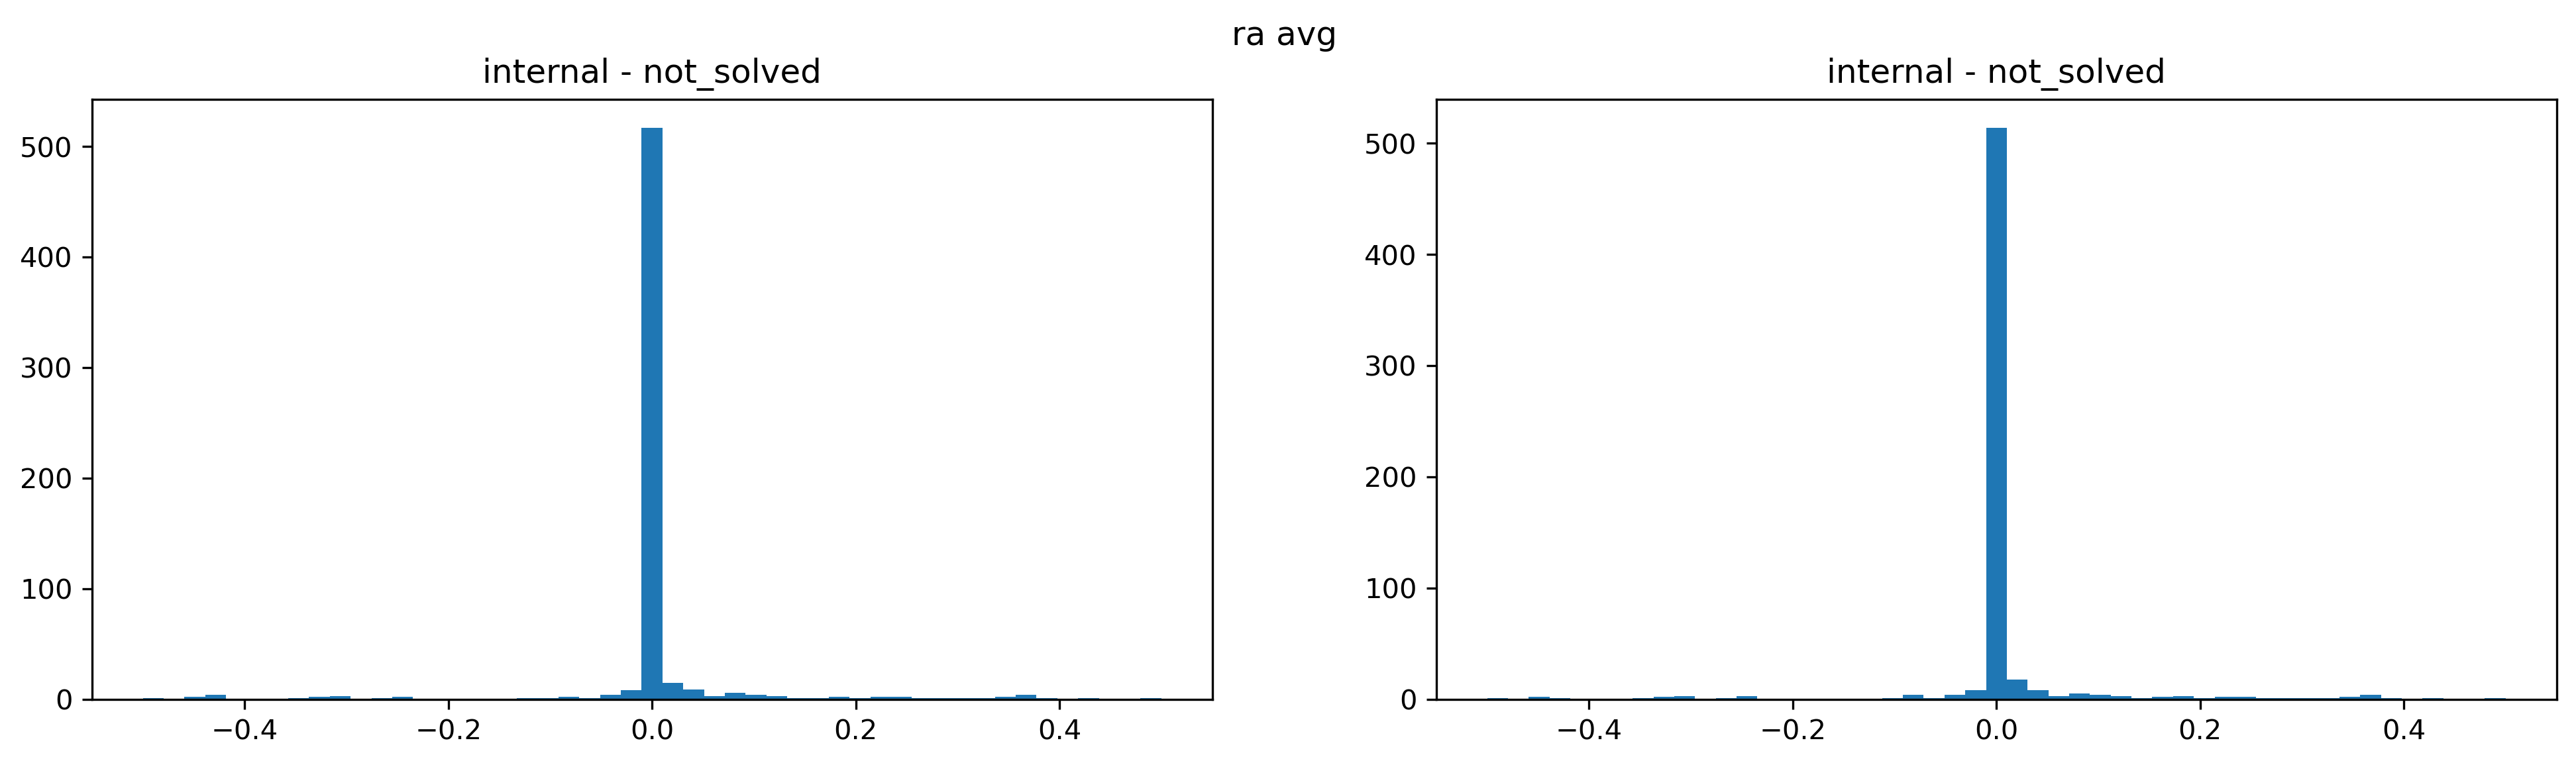

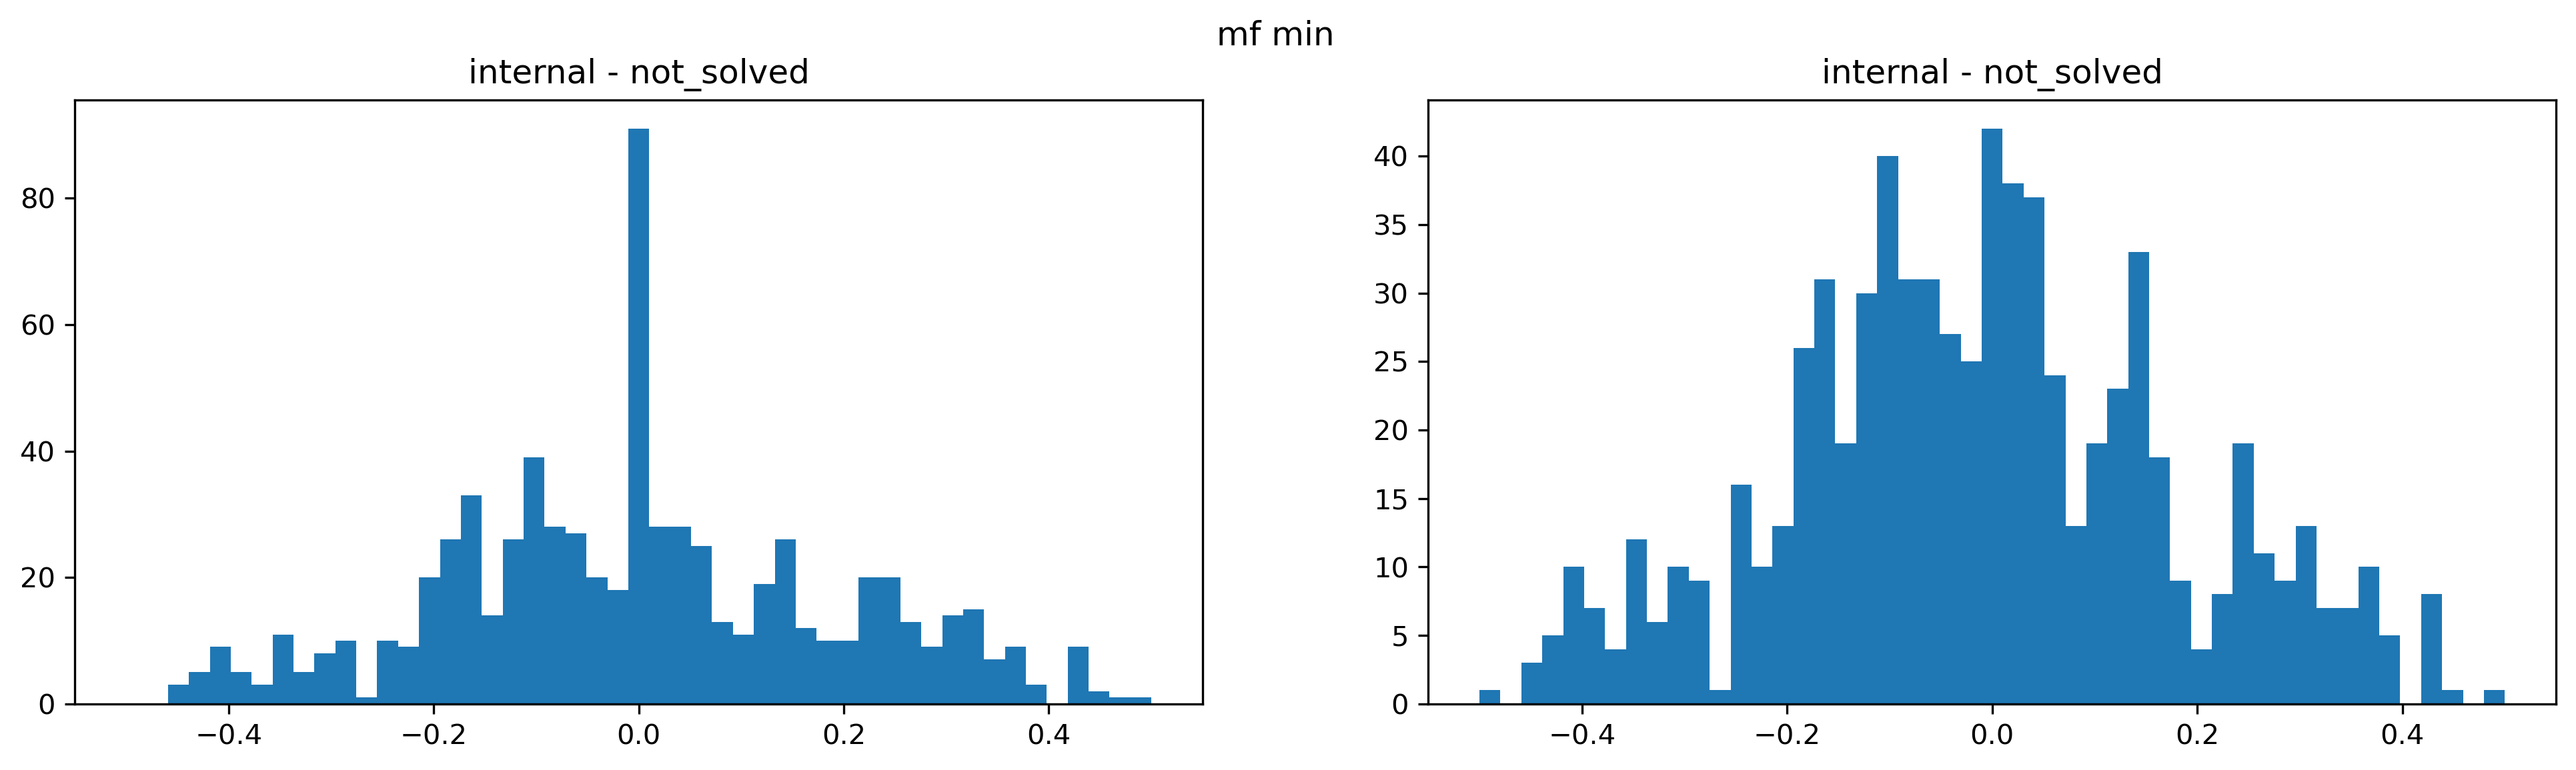

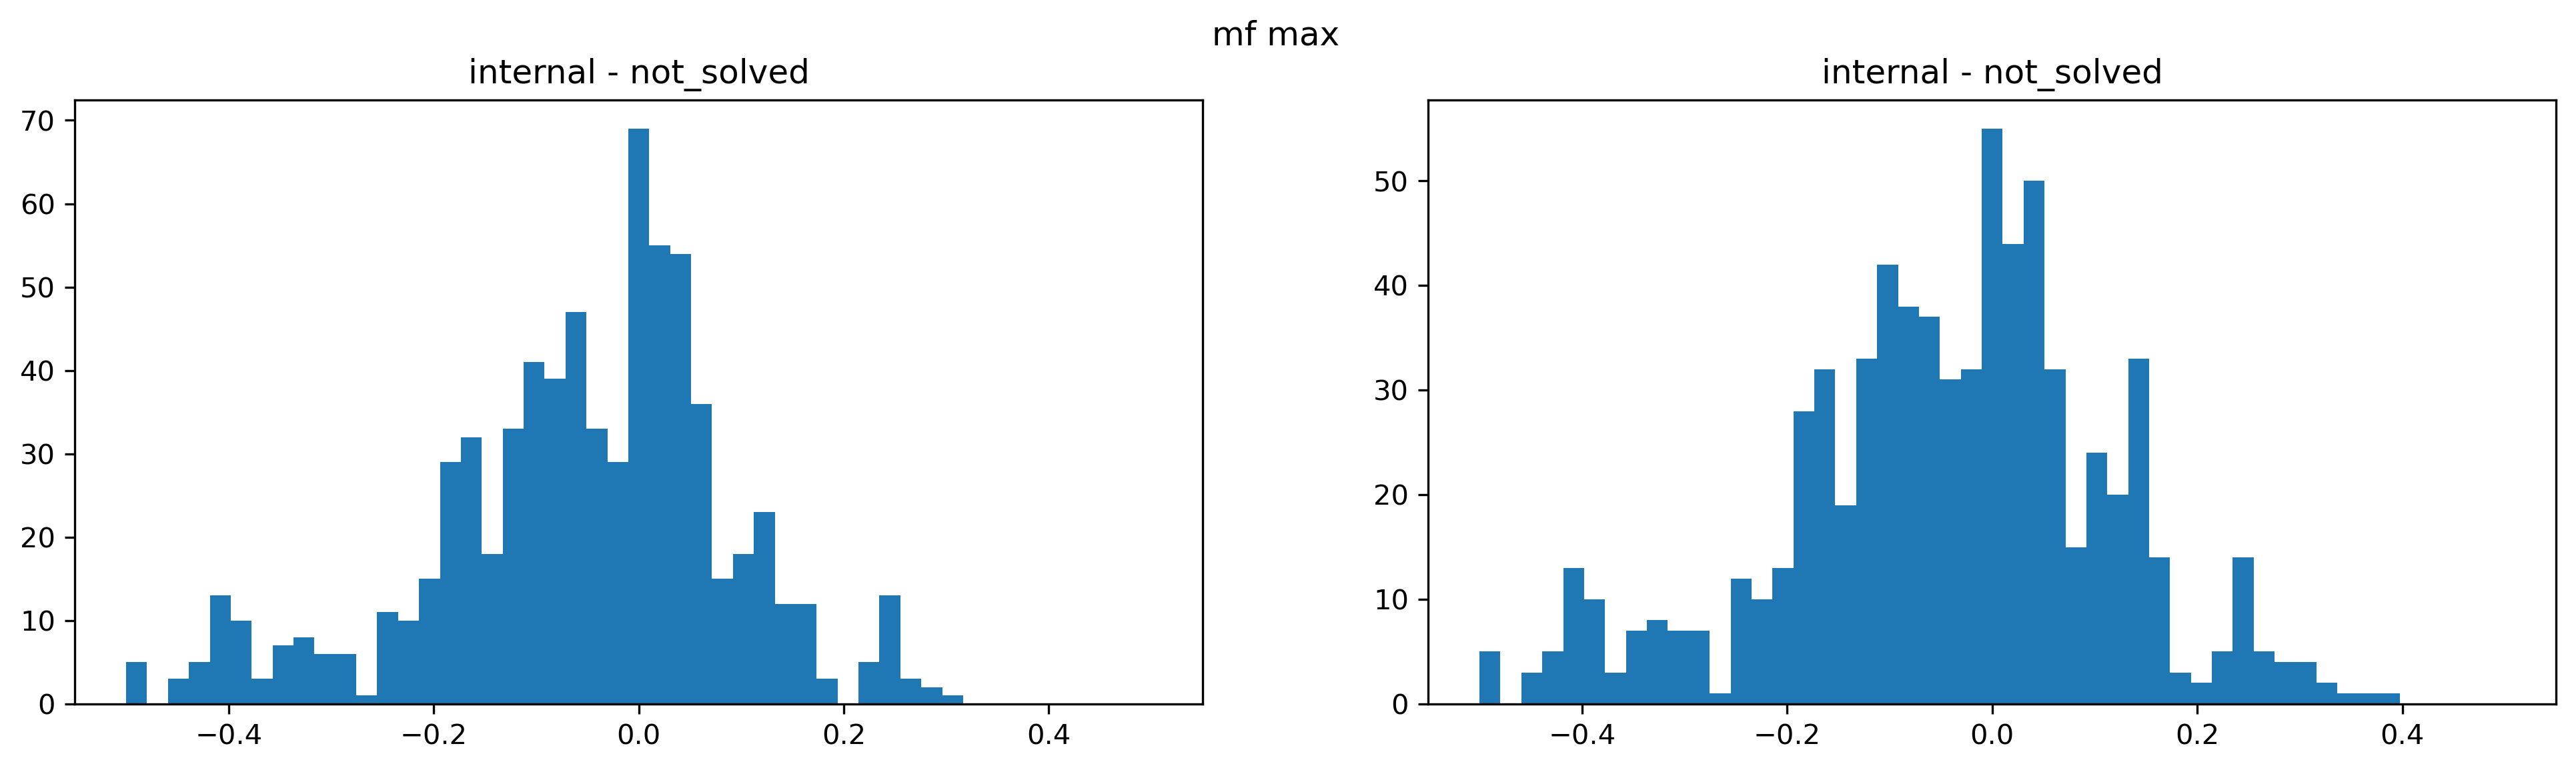

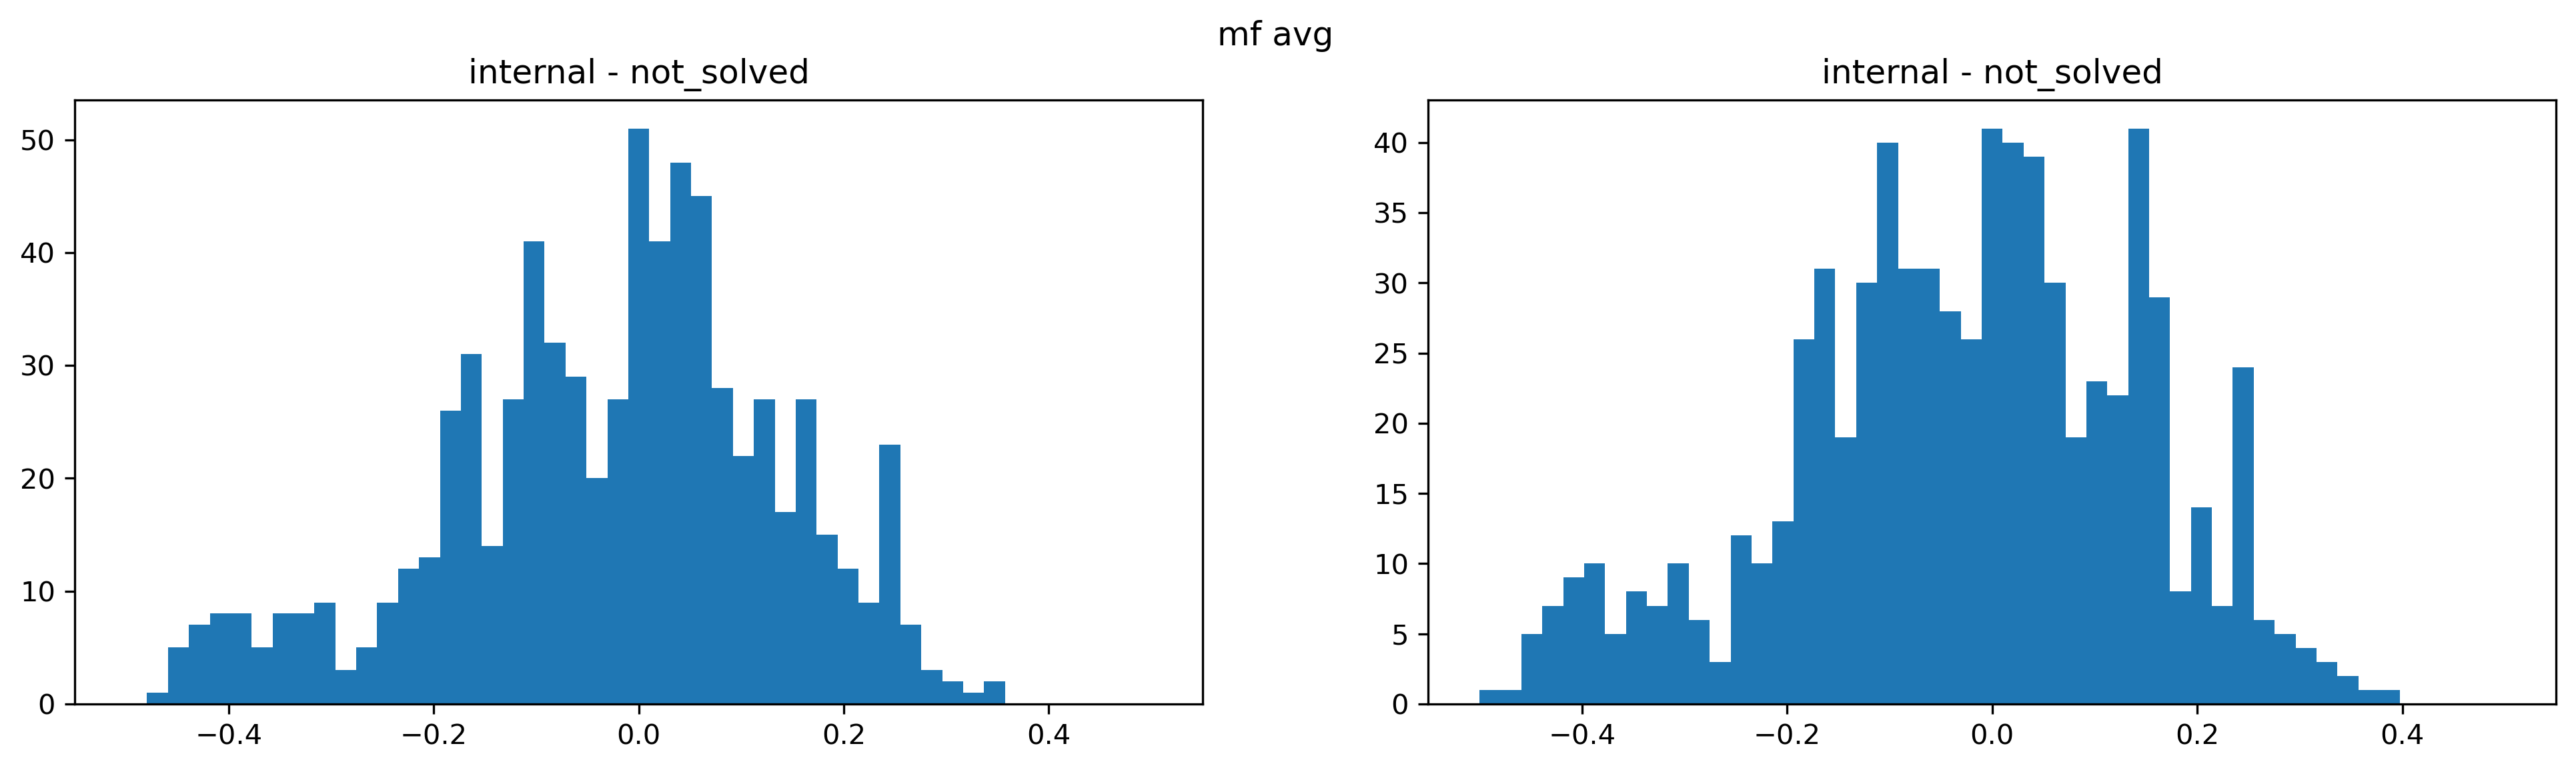

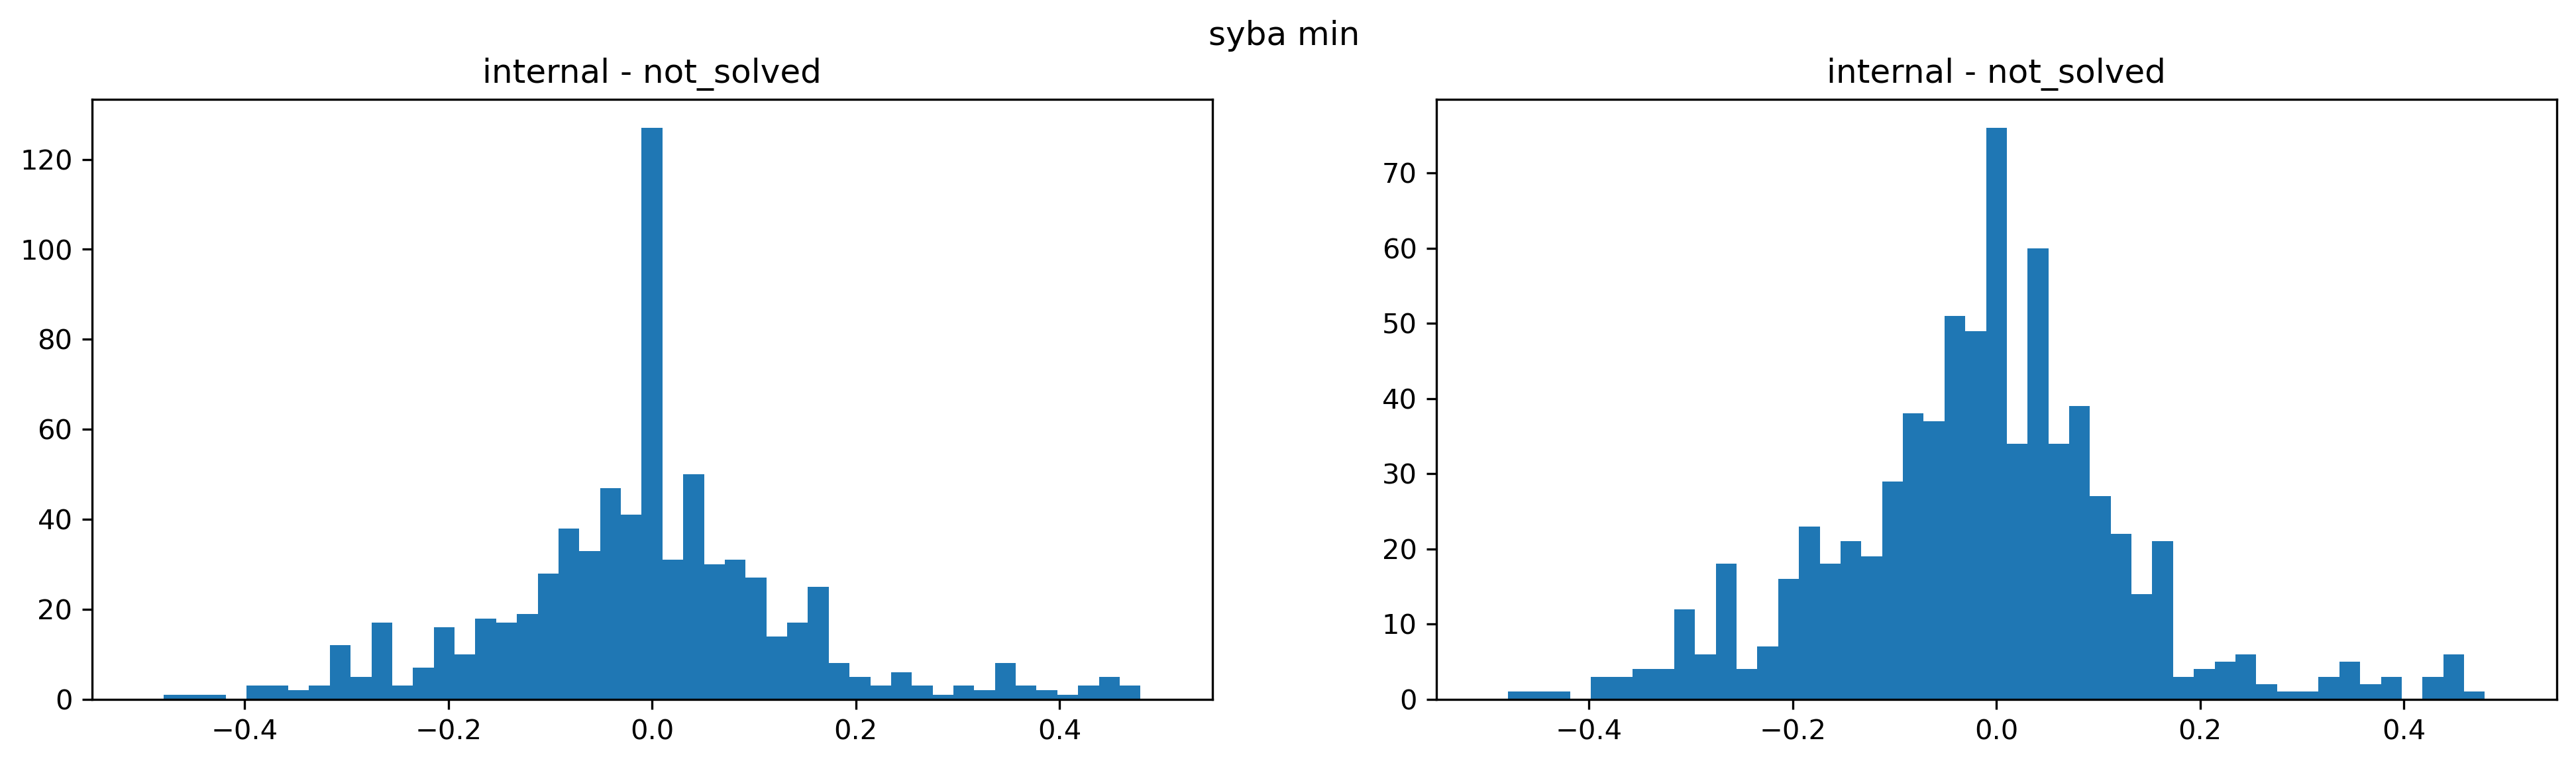

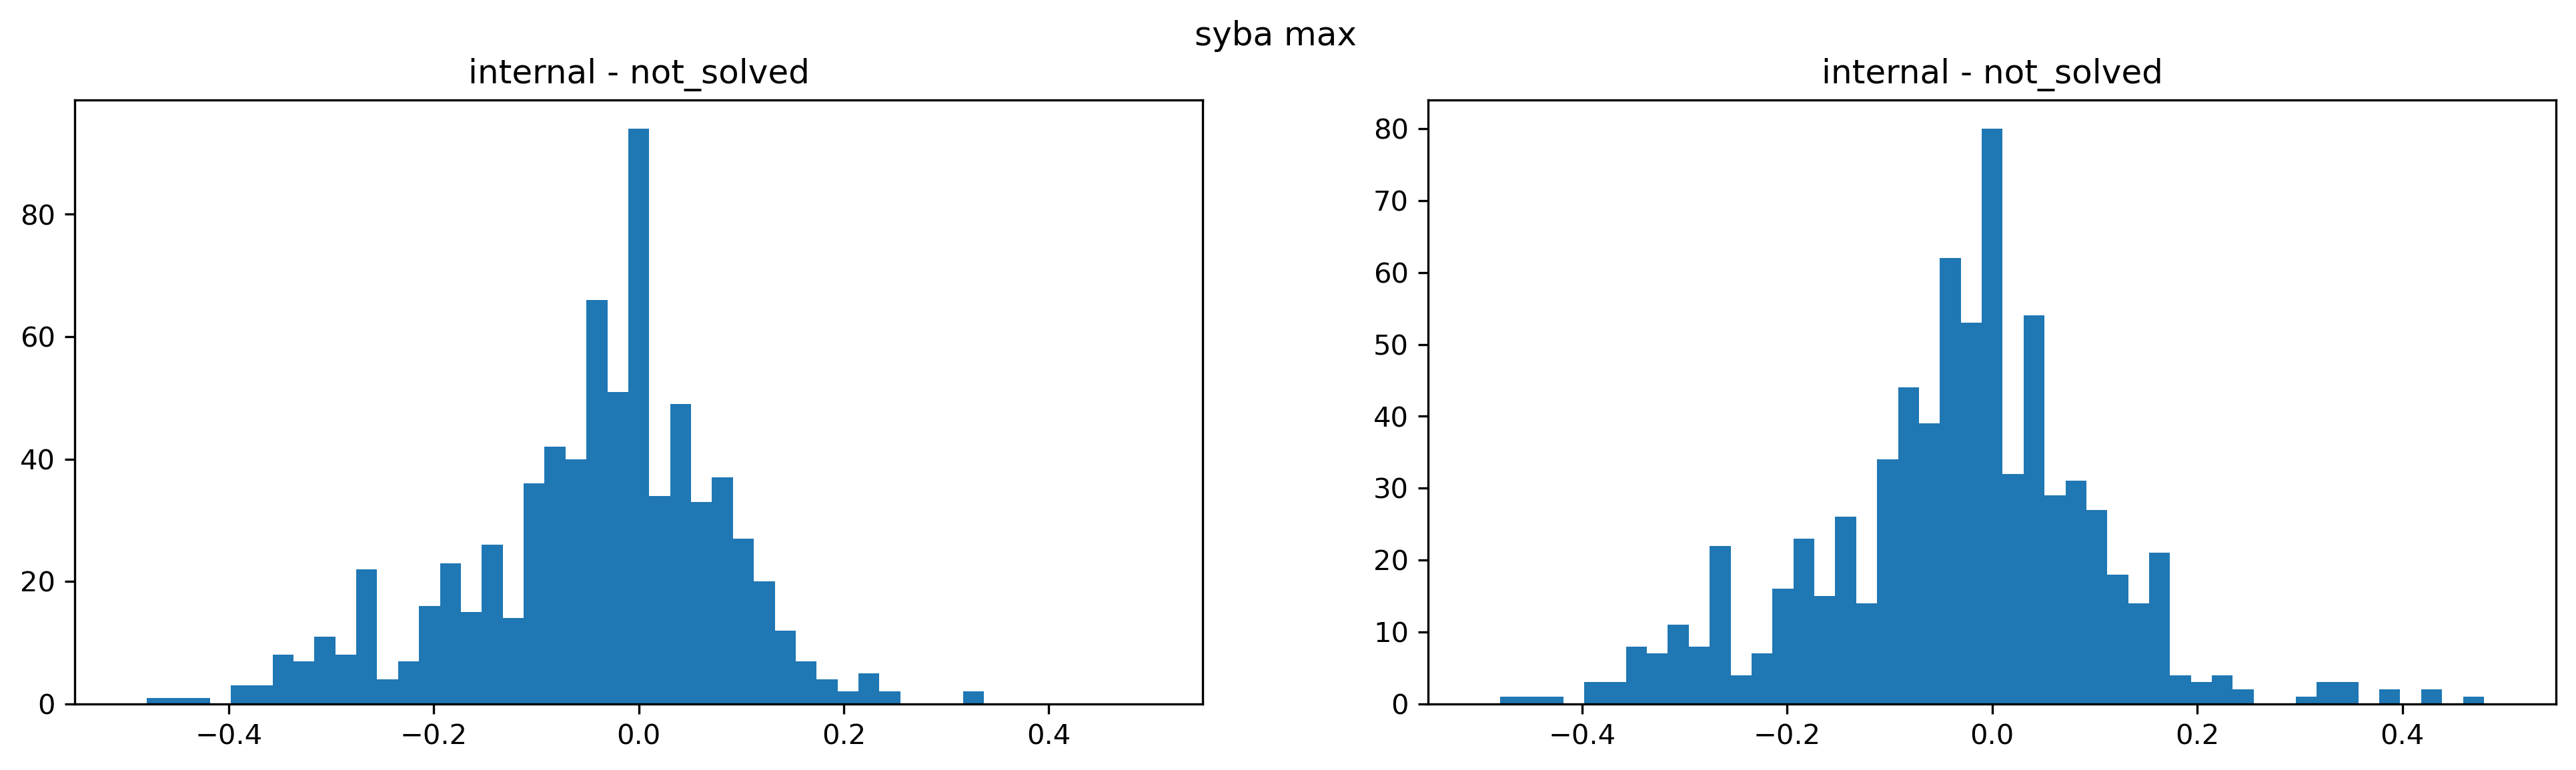

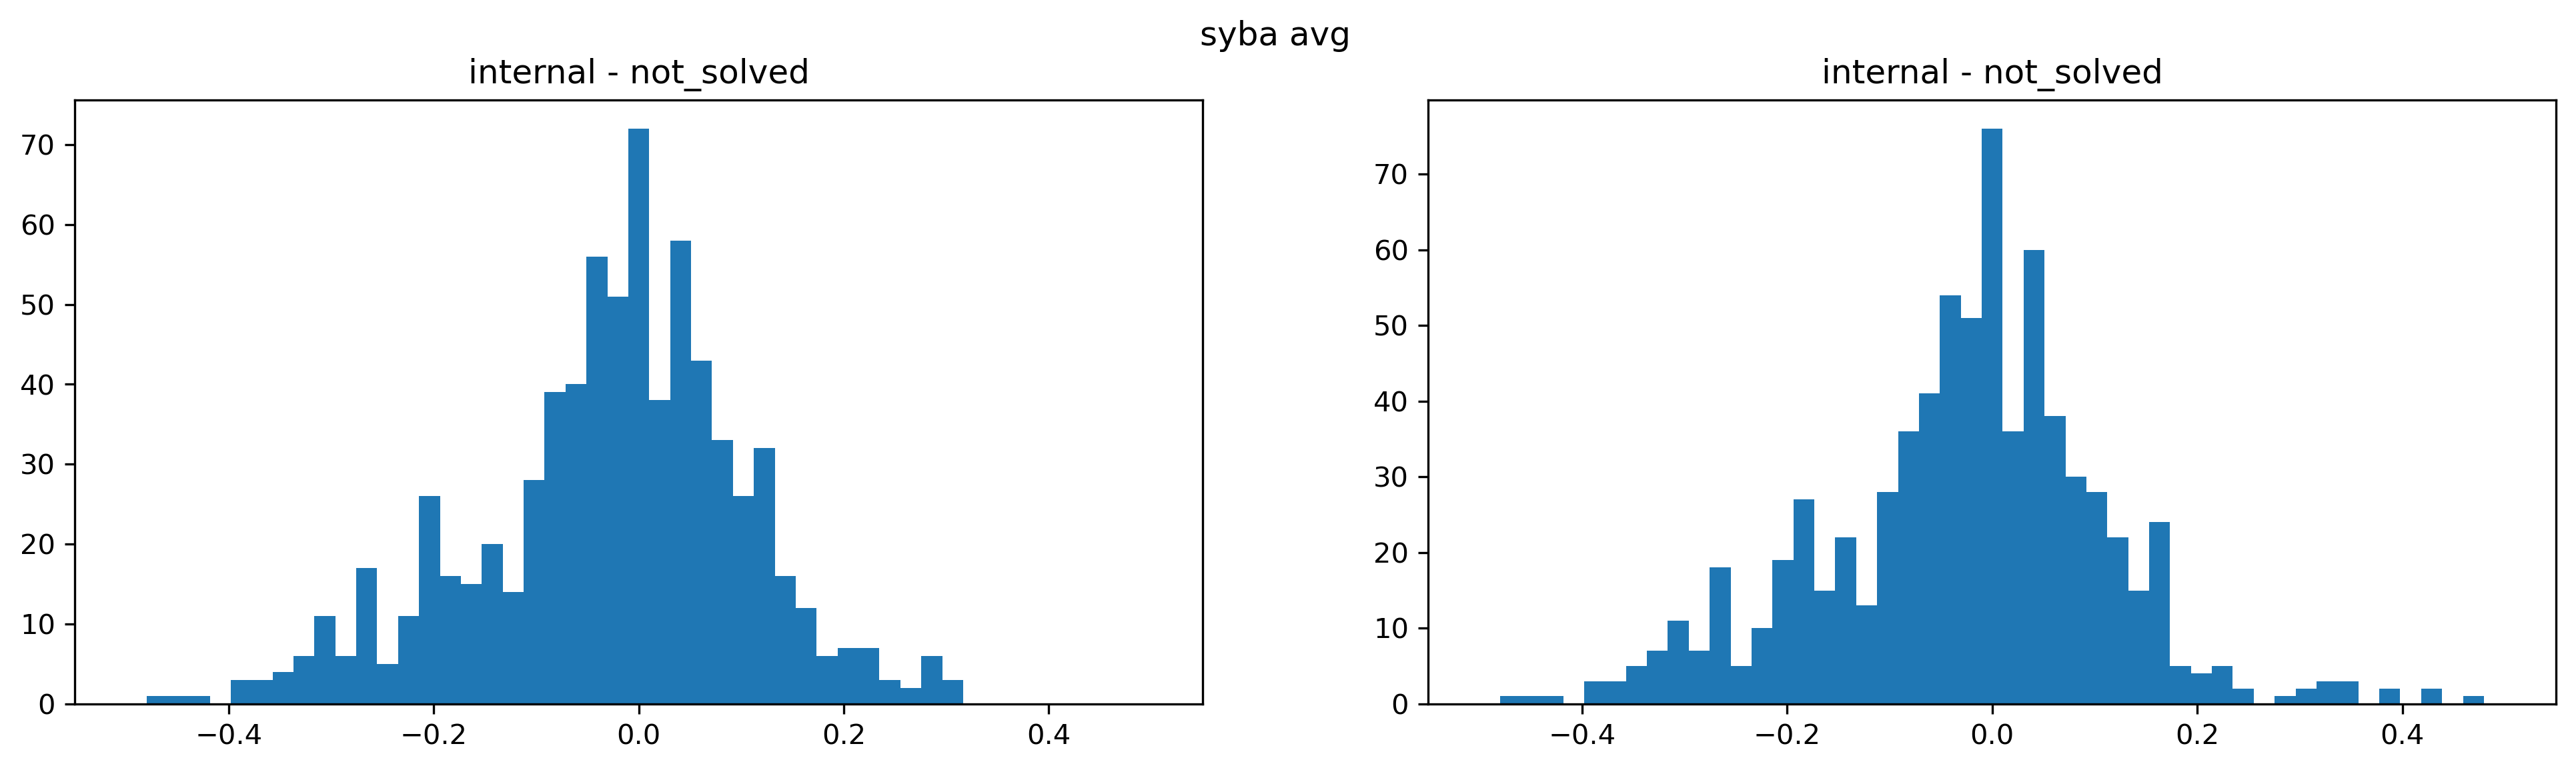

In [2]:
# Version with separate histogram for every pair type
plt.rcParams.update({'font.size': 10})

for score_name, one_picture_data in data.items():
    # Iterate over min, max, avg
    if score_name != "ai":
        for _, (agg_name, single_panel_data) in enumerate(one_picture_data):
            fig, axs = plt.subplots(nrows=1, ncols=len(analyzed_types),
                                    figsize=(16, 4), sharex=True)
            fig.set_dpi(300)
            fig.suptitle(" ".join((score_name, agg_name)))
            for panel_id, (pair_typename, one_type_pairs) in enumerate(zip(analyzed_types, single_panel_data)):
                axs[panel_id].hist(one_type_pairs, bins=np.linspace(-0.5,0.5, 50))
                axs[panel_id].set_title(", ".join(pair_typename[0]) + " - " + ", ".join(pair_typename[1]))

In [3]:
# Same as above but in table
from scipy.stats import ttest_1samp
import tabulate

title = False
rows = [[]]

# P-values of t-test for alternative hypothesis that mean is grater than 0.

for score_name, one_picture_data in data.items():
    # Iterate over min, max, avg
    if score_name != "ai" and not (score_name == "mf" and not USE_MF):
        for _, (agg_name, single_panel_data) in enumerate(one_picture_data):
            row = [" ".join((score_name, agg_name))]
            for panel_id, (pair_typename, one_type_pairs) in enumerate(zip(analyzed_types, single_panel_data)):
                if not title:
                    rows[0].append(", ".join(pair_typename[0]) + " - " + ", ".join(pair_typename[1]) + str(panel_id))
                test_result = ttest_1samp(one_type_pairs, 0, alternative="greater")
                row.append(test_result.pvalue)
            title = True
            rows.append(row)

tabulate.tabulate(rows, headers="firstrow",tablefmt='html')

,internal - not_solved0,internal - not_solved1
sa min,0.999971,0.00526663
sa max,2.40838e-17,4.93534e-17
sa avg,3.20878e-07,1.73229e-12
sc min,1,1
sc max,1,1
sc avg,1,1
ra min,1,1
ra max,1,1
ra avg,1,1
mf min,0.765094,0.992694


In [4]:
import pandas as pd

def title_transformer(title):
    return title.replace("_", " ").title()

rows_for_df = []
multiplier = rows[0]

for row in rows[1:]:
    for i, m in enumerate(multiplier):
        rows_for_df.append([title_transformer(m), row[0], row[1 + i]])
        
df = pd.DataFrame(rows_for_df)

df.to_csv(dump_name)

In [5]:
df

,0,1,2
0,Internal - Not Solved0,sa min,9.999714e-01
1,Internal - Not Solved1,sa min,5.266632e-03
2,Internal - Not Solved0,sa max,2.408378e-17
3,Internal - Not Solved1,sa max,4.935341e-17
4,Internal - Not Solved0,sa avg,3.208777e-07
5,Internal - Not Solved1,sa avg,1.732294e-12
6,Internal - Not Solved0,sc min,1.000000e+00
7,Internal - Not Solved1,sc min,1.000000e+00
8,Internal - Not Solved0,sc max,1.000000e+00
9,Internal - Not Solved1,sc max,1.000000e+00
